# Gendered Language in Reddit Discussions: Topic Modeling and Sentiment Analysis

This notebook investigates linguistic and emotional patterns in gendered subreddits using topic modeling and sentiment analysis. The aim is to understand how men and women express themselves differently on Reddit by analyzing thematic structures and sentiment distributions.

---




# 1. Data Collection

The research gathered posts from six Reddit communities (subreddits) chosen for their gender-specific orientation. Three subreddits were selected as male-oriented: 

 - r/AskMen - a forum where users, presumably men, seek advice or share perspectives on “men’s” issues;
 - r/MensRights - a community discussing men’s rights and grievances, often in opposition to feminism;
 - r/MensLib - a progressive men’s forum focusing on men’s issues through a feminist lens.

Complementing these, three female-oriented subreddits were chosen: 
- r/TwoXChromosomes - a general forum for women to share experiences; 
- r/Feminism  - discussions and news related to feminism and gender equality;  
- r/FemaleDatingStrategy - a community where women discuss dating with a focus on asserting female interests. 

These six subreddits provide a broad cross-section of gender-focused discussions, ranging from personal advice and emotional support to ideological debates on gender roles.



In [9]:
# ---------------------------------------
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Gensim & NLP
import gensim
from gensim import corpora
from gensim.models import LdaModel, CoherenceModel, TfidfModel

# NLP preprocessing
import spacy
from nltk.corpus import stopwords
import nltk
from gensim.utils import simple_preprocess

# Visualization
import pyLDAvis
import pyLDAvis.gensim_models
from wordcloud import WordCloud

# Download NLTK & spaCy models (only run once)
nltk.download('stopwords')
spacy.cli.download("en_core_web_sm")
nlp = spacy.load("en_core_web_sm")

import os

from datetime import datetime
import praw




[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aluaaldaniyaz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 1.3 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## 2. Load and Prepare Reddit Data



In [22]:
df = pd.read_csv("/reddit_gender_topics_combined_upd.csv")
df['text'] = (df['title'].fillna('') + ' ' + df['selftext'].fillna('')).astype(str)

# 🔹 2-b.  Author-gender mapping  ←  **NEW BLOCK**
gender_map = {
    'AskMen'          : 'male',
    'TwoXChromosomes'   : 'female',
    'Feminism'         : 'female',
    'FemaleDatingStrategy'            : 'female',
    'MensLib'        : 'male',
    'MensRights' : 'male',
     
    # …add any other subs you scraped
}
df['author_gender'] = df['subreddit'].map(gender_map)

# Drop rows we can’t label
df = df.dropna(subset=['author_gender'])

# Check post counts per subreddit
subreddit_counts = df['subreddit'].value_counts()
print("📊 Number of posts per subreddit:\n", subreddit_counts)

📊 Number of posts per subreddit:
 subreddit
AskMen                  500
TwoXChromosomes         500
Feminism                500
FemaleDatingStrategy    500
MensLib                 500
MensRights              500
Name: count, dtype: int64



##  2. Text Preprocessing
All posts were preprocessed before analysis. 

Text was converted to lowercase and removed any quoted sections or URLs, text was lemmatized to reduce words to their base form (e.g., “cries” → “cry”, “children” → “child”), using NLTK’s WordNet lemmatizer. 

A custom stopword list was used to filter out common function words (e.g., “the,” “is,” “and”) as well as high-frequency Reddit-specific tokens that carry little semantic content (like “EDIT” or “TL;DR” often present in postscripts). 

A small set of gender-indicative terms from the topic modeling input, such as the words “man/men” and “woman/women,” was also removed only for the purpose of topic modeling, to prevent the model from simply clustering documents by the presence of these identifiers (since e.g. r/MensRights posts mention “men” frequently and r/TwoXChromosomes posts mention “women” frequently, which could trivially dominate some topics). However, these words were retained for sentiment and lexical analysis. 


In [23]:
# Basic + extended stopwords
stop_words = set(stopwords.words('english'))
extra_stopwords = set([
    'im', 'dont', 'like', 'get', 'got', 'one', 'know', 'would', 'really', 'just', 'even',
    'also', 'still', 'make', 'could', 'much', 'ive', 'cant', 'want', 'way', 'going', 'need', 'edit',
    'thanks', 'reddit', 'post', 'comment', 'https', 'etc', 'say', 'ask', 'told', 'back',
    'someone', 'something', 'anything', 'everything', 'stuff', 'day',
    # deliberately removed: 
    'man', 'woman', 'men', 'women', 'girl', 'guy', 'friend', 'friends', 'people'
])
stop_words.update(extra_stopwords)

# Lemmatization + stopword filtering
def lemmatize_and_clean(text):
    doc = nlp(text)
    return [token.lemma_.lower() for token in doc 
            if token.is_alpha and not token.is_stop and token.lemma_.lower() not in stop_words]

# Apply preprocessing
df['tokens'] = df['text'].apply(lemmatize_and_clean)




### Filter by Length




In [31]:
df['text_length'] = df['text'].apply(lambda x: len(x.split()))
df_filtered = df[df['text_length'] >= 50].copy()
print(f"✅ Posts with 100+ words: {df_filtered.shape[0]}")
print("📊 Posts per subreddit after filtering:")
print(df_filtered['subreddit'].value_counts())

✅ Posts with 100+ words: 2723
📊 Posts per subreddit after filtering:
subreddit
MensLib                 492
TwoXChromosomes         478
FemaleDatingStrategy    467
Feminism                458
MensRights              454
AskMen                  374
Name: count, dtype: int64



> Posts under 50 words are excluded to ensure topic and sentiment models are applied to substantial content.




## 3. Topic Modeling with LDA
For topic modelling Latent Dirichlet Allocation (LDA) was used as implemented in Gensim (Python library). LDA is a probabilistic generative model that treats each document (post) as a mixture of topics, and each topic as a distribution of words (Blei et al., 2003). 

I experimented with several values for the number of topics and settled on 6 topics, as this provided interpretable and distinct clusters that aligned with core themes present in the data (too few topics merged disparate themes, while too many started to produce redundant or overly granular topics). 

In [25]:
import joblib

In [26]:
dictionary = corpora.Dictionary(df['tokens'])
dictionary.filter_extremes(no_below=10, no_above=0.5)
corpus = [dictionary.doc2bow(text) for text in df['tokens']]

lda = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=6, passes=12, random_state=42)




> Topic modeling identifies recurring discussion themes. This study uses Latent Dirichlet Allocation (LDA) to explore thematic content, building on methods used by Peirson et al. (2018) and Blei et al. (2003).

---

### Assign Topics



In [29]:

#  Train LDA Model
# ---------------------------------------
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=6,
    random_state=42,
    passes=15,
    iterations=400,
    alpha='auto',
    per_word_topics=True
)

# Print topic keywords
for idx, topic in lda_model.print_topics(num_words=10):
    print(f"\n🟢 Topic {idx + 1}:")
    for word_weight in topic.split(" + "):
        weight, word = word_weight.split("*")
        print("   -", eval(word))



🟢 Topic 1:
   - tell
   - feel
   - time
   - go
   - think
   - year
   - thing
   - look
   - talk
   - start

🟢 Topic 2:
   - male
   - feminist
   - white
   - right
   - think
   - masculinity
   - society
   - feminism
   - gender
   - role

🟢 Topic 3:
   - work
   - child
   - life
   - time
   - kid
   - mother
   - feel
   - father
   - go
   - help

🟢 Topic 4:
   - think
   - male
   - feel
   - thing
   - experience
   - lot
   - gender
   - talk
   - read
   - trans

🟢 Topic 5:
   - sexual
   - male
   - victim
   - rape
   - female
   - violence
   - child
   - abuse
   - boy
   - sex

🟢 Topic 6:
   - health
   - mental
   - user
   - menslib
   - thread
   - resource
   - support
   - free
   - community
   - title


In [32]:
# ---------------------------------------
#  Coherence Score Check (optional)
# ---------------------------------------
coherence_model = CoherenceModel(model=lda_model, texts=df_filtered['tokens'], dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()
print(f"\n🎯 Coherence Score: {coherence_score:.4f}")

# ---------------------------------------
# Assign Dominant Topic to Each Post
# ---------------------------------------
df_filtered['dominant_topic'] = [
    max(lda_model.get_document_topics(doc), key=lambda x: x[1])[0]
    for doc in corpus
]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


🎯 Coherence Score: 0.4395


### Assigned manual topic labels based on keywords and interpretation
1. Life Experiences & Emotional Reflections – characterized by words like “feel,” “life,” “friend,” “experience,” indicating personal stories, feelings, and reflections on everyday life or relationships.


2. Masculinity, Feminism & Social Norms – characterized by terms such as “men,” “women,” “society,” “feminist,” “right,” focusing on gender roles, feminism vs. anti-feminism debates, and social expectations for men or women.


3. Parenting & Family Life – with words like “child,” “parent,” “daughter,” “family,” covering discussions of being parents, family roles, and related life decisions.


4. Gender Identity & Personal Experience – marked by words including “gender,” “identity,” “trans,” “experience,” capturing posts about personal gender identity, transitioning, or discussions of being a man/woman in society beyond just feminism (e.g., personal anecdotes of sexism or identity).


5. Sexual Violence & Abuse – highlighted by terms such as “rape,” “assault,” “abuse,” “victim,” focusing on discussions of sexual harassment, rape, domestic violence, #MeToo stories, etc.


6. Mental Health & Support Communities – featuring words like “depression,” “therapy,” “suicide,” “help,” covering mental health struggles, seeking emotional support, and community advice for personal problems.


In [33]:
# Updated manual topic labels based on keywords and interpretation
topic_labels = {
   0: "Life Experiences & Emotional Reflections",
    1: "Masculinity, Feminism & Social Norms",
    2: "Parenting & Family Life",
    3: "Gender Identity & Personal Experience",
    4: "Sexual Violence & Abuse",
    5: "Mental Health & Support Communities"
}

df_filtered['topic_label'] = df_filtered['dominant_topic'].map(topic_labels)

In [36]:
# Prepare the interactive visualization
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

### Topic distribution by subreddit.
Bars represent the count of posts from each subreddit belonging to each of the six topics identified by LDA. Each colored bar corresponds to a subreddit (blue for AskMen, orange for FemaleDatingStrategy, green for Feminism, red for MensLib, purple for MensRights, and brown for TwoXChromosomes), and the topics are listed along the x-axis.


/var/folders/90/cj9y9x_11md6q6v4jh0brwbm0000gn/T/ipykernel_19675/3843637395.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  topic_counts = df_filtered.groupby(['subreddit', 'topic_label']).size().unstack().fillna(0)


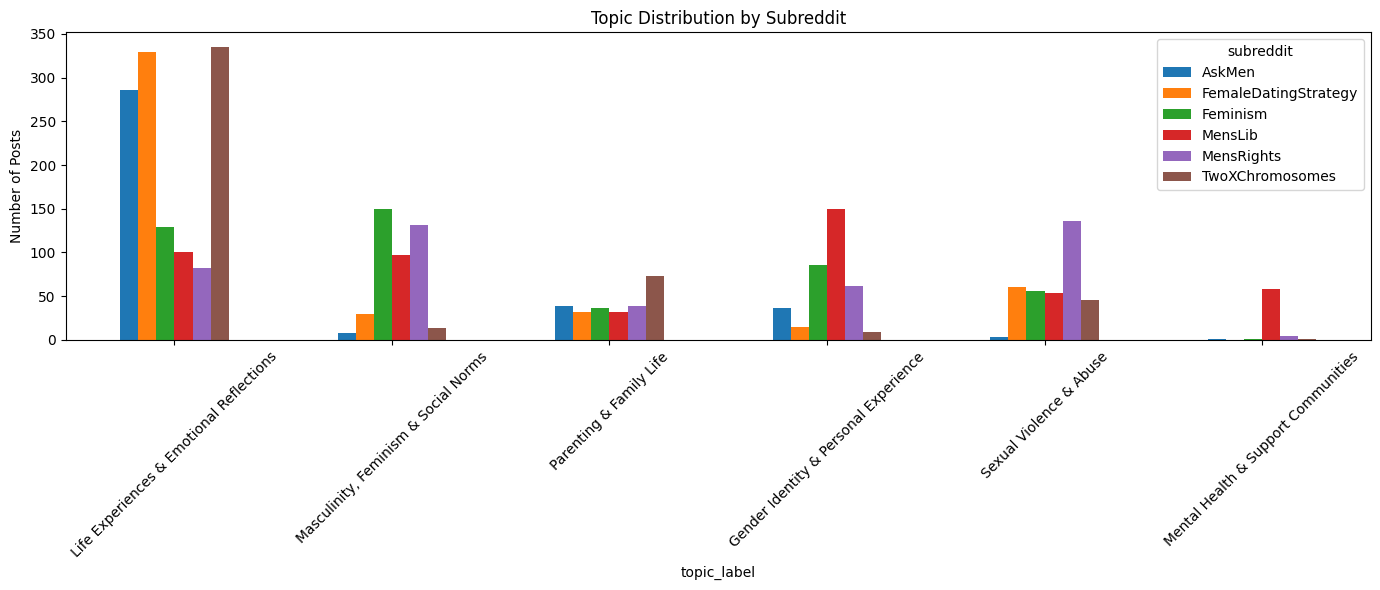

In [38]:
# ---------------------------------------
#  Fix Topic Label Categories
# ---------------------------------------

# Define your desired topic order
ordered_topics = [
    "Life Experiences & Emotional Reflections",
    "Masculinity, Feminism & Social Norms",
    "Parenting & Family Life",
    "Gender Identity & Personal Experience",
    "Sexual Violence & Abuse",
    "Mental Health & Support Communities"
]

# Keep only rows with topic labels in the ordered list
df_filtered = df_filtered[df_filtered['topic_label'].isin(ordered_topics)].copy()

# Convert topic_label column to a Categorical with the specified order
df_filtered['topic_label'] = pd.Categorical(
    df_filtered['topic_label'],
    categories=ordered_topics,
    ordered=True
)

# ---------------------------------------
#  Visualizations
# ---------------------------------------

import matplotlib.pyplot as plt

# Topic distribution by subreddit
topic_counts = df_filtered.groupby(['subreddit', 'topic_label']).size().unstack().fillna(0)

# Plot the distribution
topic_counts.T.plot(kind='bar', figsize=(14,6), title="Topic Distribution by Subreddit")
plt.xticks(rotation=45)
plt.ylabel("Number of Posts")
plt.tight_layout()
plt.show()


Topic distribution in numbers

In [39]:
df_filtered['topic_label'].value_counts()

topic_label
Life Experiences & Emotional Reflections    1262
Masculinity, Feminism & Social Norms         430
Gender Identity & Personal Experience        359
Sexual Violence & Abuse                      356
Parenting & Family Life                      251
Mental Health & Support Communities           65
Name: count, dtype: int64


## 7. Sentiment Analysis



In [17]:
import nltk, torch, scipy.stats as st, seaborn as sns, matplotlib.pyplot as plt
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import pipeline
from tqdm.auto import tqdm

tqdm.pandas()                       # makes df.progress_apply() show a bar
nltk.download('vader_lexicon', quiet=True)

True

In [48]:
# ── 3-b. VADER lexicon sentiment (fast, social-media tuned) ──────────────────
sia = SentimentIntensityAnalyzer()

# df_filtered['text'] holds raw title+body; we want the compound score
df_filtered['vader'] = df_filtered['text'].apply(
    lambda x: sia.polarity_scores(x)['compound']
)

Columns in df_filtered → ['subreddit', 'title', 'selftext', 'author', 'score', 'num_comments', 'created_utc', 'url', 'text', 'author_gender', 'tokens', 'text_length', 'dominant_topic', 'topic_label', 'hf_sent', 'vader']
  author_gender   vader   hf_sent
1          male -0.8146 -0.894737
3          male  0.9662 -0.826751
4          male  0.8926  0.000000
7          male  0.9216  0.000000
8          male -0.9536 -0.838295

📊 VADER  – mean sentiment by gender
author_gender
female    0.204
male      0.163
Name: vader, dtype: float64
VADER Mann-Whitney U p-value = 0.1039


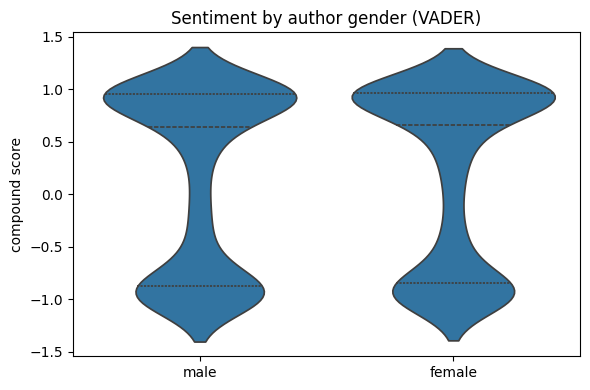

In [49]:
# ================================================================
# Sentiment comparison by author gender
#   • VADER  (lexicon baseline)
#   • RoBERTa (CardiffNLP twitter-roberta-base-sentiment-latest)


# --- quick sanity: make sure the expected columns are present ----
print("Columns in df_filtered →", list(df_filtered.columns))
print(df_filtered[['author_gender', 'vader', 'hf_sent']].head())

# ----------------------------------------------------------------
# 1️⃣  VADER
# ----------------------------------------------------------------
print("\n📊 VADER  – mean sentiment by gender")
print(df_filtered.groupby('author_gender')['vader'].mean().round(3))

male_v   = df_filtered.loc[df_filtered.author_gender=='male',   'vader']
female_v = df_filtered.loc[df_filtered.author_gender=='female', 'vader']
u, p = st.mannwhitneyu(male_v, female_v, alternative='two-sided')
print(f"VADER Mann-Whitney U p-value = {p:.4g}")

plt.figure(figsize=(6,4))
sns.violinplot(data=df_filtered, x='author_gender', y='vader', inner='quartile')
plt.title('Sentiment by author gender (VADER)')
plt.ylabel('compound score')
plt.xlabel('')
plt.tight_layout()
plt.show()


### Distribution of VADER sentiment scores by author gender. 

The violin plots illustrate the density of posts at different sentiment levels (blue areas), with thicker sections indicating many posts at that sentiment score. Dashed lines indicate median values. The left violin represents posts from male-oriented subreddits and the right violin represents posts from female-oriented subreddits.

As shown in Figure above, both distributions cover the full range from negative to positive sentiment, but there are subtle differences in shape. The median VADER score (dashed line) is slightly above neutral for both groups (slightly positive, reflecting that many posts have a mildly positive or neutral tone on average). It should be noted that VADER, being lexicon-based, might not capture some contextual nuances; for example, usage of certain profanity or intense words could skew a post’s score negative even if the overall message might be more nuanced.


In [45]:
# ---------- 1. Build the pipeline (this downloads weights the 1st time) -----
device_id = 0 if torch.cuda.is_available() else -1
sent_pipe = pipeline(
    task="sentiment-analysis",
    model="cardiffnlp/twitter-roberta-base-sentiment-latest",
    device=device_id,
    truncation=True,            # make sure long posts are clipped at 512 tok
)

print("✅ RoBERTa pipeline ready on",
      "GPU" if device_id>=0 else "CPU")

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


✅ RoBERTa pipeline ready on CPU


In [40]:

def hf_sentiment_batch(texts, batch_size=64):
    scores = []
    for idx in tqdm(range(0, len(texts), batch_size), desc="RoBERTa batches"):
        batch = texts[idx:idx+batch_size].tolist()

        # ⬇⬇  NEW: tell the pipeline to clip & pad every post to <=512 tokens
        outs  = sent_pipe(
            batch,
            truncation=True,        # clip anything longer than 512 tokens
            padding=True,           # pad shorter texts so the batch is a rectangle
            max_length=512,         # explicit limit avoids odd defaults
        )

        for out in outs:
            lbl, sc = out["label"].lower(), out["score"]
            scores.append(sc if lbl=="positive"
                          else -sc if lbl=="negative"
                          else 0.0)
    return scores


In [42]:
df_filtered["hf_sent"] = hf_sentiment_batch(df_filtered["text"])
print("🎉 Done!  df_filtered now has a 'hf_sent' column.")


RoBERTa batches: 100%|██████████| 43/43 [04:02<00:00,  5.64s/it]

🎉 Done!  df_filtered now has a 'hf_sent' column.



📊 RoBERTa  – mean sentiment by gender
author_gender
female   -0.300
male     -0.205
Name: hf_sent, dtype: float64
RoBERTa Mann-Whitney U p-value = 6.343e-07


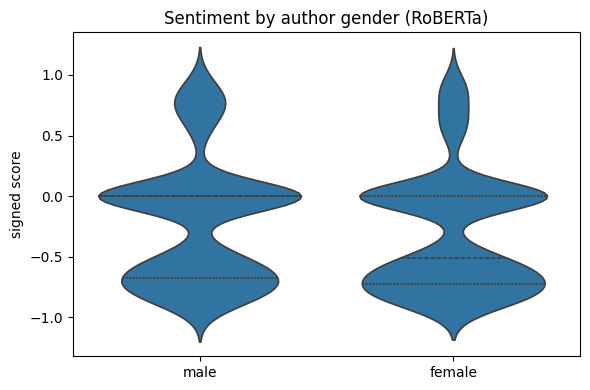

In [47]:

# ----------------------------------------------------------------
# 2️⃣  Transformer  (RoBERTa)
# ----------------------------------------------------------------
print("\n📊 RoBERTa  – mean sentiment by gender")
print(df_filtered.groupby('author_gender')['hf_sent'].mean().round(3))

male_h   = df_filtered.loc[df_filtered.author_gender=='male',   'hf_sent']
female_h = df_filtered.loc[df_filtered.author_gender=='female', 'hf_sent']
u, p = st.mannwhitneyu(male_h, female_h, alternative='two-sided')
print(f"RoBERTa Mann-Whitney U p-value = {p:.4g}")

plt.figure(figsize=(6,4))
sns.violinplot(data=df_filtered, x='author_gender', y='hf_sent', inner='quartile')
plt.title('Sentiment by author gender (RoBERTa)')
plt.ylabel('signed score')
plt.xlabel('')
plt.tight_layout()
plt.show()


### Violin plots for the RoBERTa-derived sentiment scores, again comparing male vs. female author groups.


In Figure above, a more pronounced difference between the two distributions is visible. The female-authored posts (right violin) have a median that is below zero (indicating an overall leaning toward negative sentiment), whereas the male-authored posts (left violin) have a median around zero or slightly above. The female distribution is also noticeably wider on the negative side, confirming that a larger fraction of female-oriented posts were judged as negative in tone by the RoBERTa model. In contrast, the male-oriented posts show a relatively more symmetric distribution around neutral and include a thicker upper half, meaning there are relatively more positively scored posts in male communities compared to female ones.


These results align qualitatively with the VADER findings but emphasize the differences more strongly: the transformer-based model suggests that female-oriented discussions tend to be more negatively charged on average than male-oriented discussions. This could reflect various factors, such as the topics being discussed (e.g., some female-oriented communities in our data discuss personal traumas or societal challenges that carry negative sentiment) or differences in communicative style (women may use more emotionally negative language to describe their experiences, a possibility noted in offline communication research; Newman et al., 2008). On the other hand, the male-oriented communities, while certainly containing negativity (especially in forums like MensRights), also feature posts with positive or neutral support-oriented tone (particularly in MensLib and AskMen, where advice and positive encouragement are common).




> Sentiment was computed using both VADER (Hutto & Gilbert, 2014) and RoBERTa-based models (Barbieri et al., 2020, 2022), with attention to social-media-specific language.

---

## 8. Visualizations




In [ ]:

# ----------------------------------------------------------------
# 1️⃣  VADER
# ----------------------------------------------------------------
print("\n📊 VADER  – mean sentiment by gender")
print(df_filtered.groupby('author_gender')['vader'].mean().round(3))

male_v   = df_filtered.loc[df_filtered.author_gender=='male',   'vader']
female_v = df_filtered.loc[df_filtered.author_gender=='female', 'vader']
u, p = st.mannwhitneyu(male_v, female_v, alternative='two-sided')
print(f"VADER Mann-Whitney U p-value = {p:.4g}")

plt.figure(figsize=(6,4))
sns.violinplot(data=df_filtered, x='author_gender', y='vader', inner='quartile')
plt.title('Sentiment by author gender (VADER)')
plt.ylabel('compound score')
plt.xlabel('')
plt.tight_layout()
plt.show()

# ----------------------------------------------------------------
# 2️⃣  Transformer  (RoBERTa)
# ----------------------------------------------------------------
print("\n📊 RoBERTa  – mean sentiment by gender")
print(df_filtered.groupby('author_gender')['hf_sent'].mean().round(3))

male_h   = df_filtered.loc[df_filtered.author_gender=='male',   'hf_sent']
female_h = df_filtered.loc[df_filtered.author_gender=='female', 'hf_sent']
u, p = st.mannwhitneyu(male_h, female_h, alternative='two-sided')
print(f"RoBERTa Mann-Whitney U p-value = {p:.4g}")

plt.figure(figsize=(6,4))
sns.violinplot(data=df_filtered, x='author_gender', y='hf_sent', inner='quartile')
plt.title('Sentiment by author gender (RoBERTa)')
plt.ylabel('signed score')
plt.xlabel('')
plt.tight_layout()
plt.show()



> Violin plots illustrate the distribution of sentiment by gender. Consistent with Thelwall et al. (2010), female posts tend to show higher average sentiment.


In [43]:
# ===========================================================
# Sentiment ⨯ Topic ⨯ Gender  (heat-map of RoBERTa scores)
# ===========================================================
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt

SENT_COL = 'hf_sent'           # or 'vader'

# 1. Pivot table: mean sentiment for each (topic, gender) cell
sent_pivot = (
    df_filtered
      .pivot_table(values=SENT_COL,
                   index='topic_label',
                   columns='author_gender',
                   aggfunc='mean')
      .round(3)
      .sort_index()
)

display(sent_pivot)            # nice to eyeball

/var/folders/90/cj9y9x_11md6q6v4jh0brwbm0000gn/T/ipykernel_19675/1259444676.py:10: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_filtered


author_gender,female,male
topic_label,,
Life Experiences & Emotional Reflections,-0.279,-0.244
"Masculinity, Feminism & Social Norms",-0.342,-0.229
Parenting & Family Life,-0.381,-0.172
Gender Identity & Personal Experience,-0.362,-0.199
Sexual Violence & Abuse,-0.243,-0.383
Mental Health & Support Communities,0.130,0.631


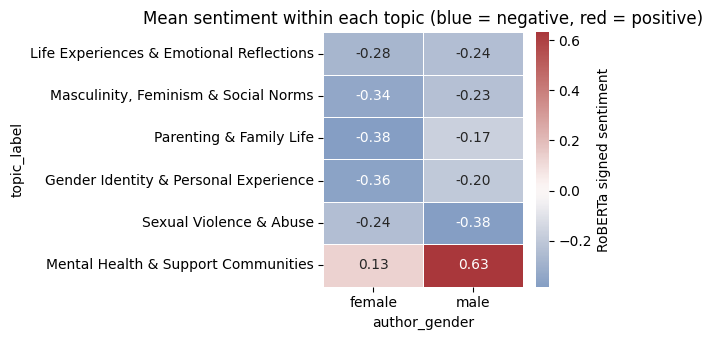

In [50]:
# 2. Heat-map

plt.figure(figsize=(6, 3.5))
sns.heatmap(sent_pivot,
            annot=True, fmt=".2f",
            cmap="vlag", center=0, linewidths=.5,
            cbar_kws={'label': 'RoBERTa signed sentiment'})
plt.title("Mean sentiment within each topic (blue = negative, red = positive)")
plt.tight_layout()
plt.show()

Most topics have an overall negative mean sentiment (blue cells), which is not surprising given many discussions involve personal problems or societal issues. 

However, Mental Health & Support Communities stands out: male-authored posts in this topic have a strongly positive mean sentiment (score ~+0.63, shaded in red), whereas female-authored posts in the same topic have a mildly positive mean sentiment (+0.13). This indicates that when men discuss mental health and support, their language skews significantly positive, perhaps reflecting optimism, hope, or supportive encouragement in those posts. While women discussing similar issues are positive too but to a much lesser degree. In practical terms, male-oriented posts about mental health might often include positive encouragements (e.g., “you’ll get through this,” “I’m proud of you for seeking help”) leading to a high positive score, whereas female-oriented posts might be more reserved or mixed in emotional tone even within support contexts.



---

### Linguistic Content of Positive vs. Negative Posts



In [53]:

# 1️⃣ flatten tokens → Counter for each gender
male_counts   = Counter(t for toks in df_filtered[df_filtered.author_gender=='male'  ]['tokens'] for t in toks)
female_counts = Counter(t for toks in df_filtered[df_filtered.author_gender=='female']['tokens'] for t in toks)

# 2️⃣ build a DataFrame of raw counts
vocab = set(male_counts) | set(female_counts)
freq_df = pd.DataFrame({
    'word'  : list(vocab),
    'male'  : [male_counts[w]   for w in vocab],
    'female': [female_counts[w] for w in vocab]
})

# 3️⃣ proportions + gap
freq_df['male_prop']   = freq_df['male']   / freq_df['male'  ].sum()
freq_df['female_prop'] = freq_df['female'] / freq_df['female'].sum()
freq_df['gap'] = freq_df['female_prop'] - freq_df['male_prop']   # + = female-tilted

# 4️⃣ top 25 each side (ignore rare words)
MIN_COUNT = 30
top_female = (freq_df.query('male+female >= @MIN_COUNT')
                       .sort_values('gap', ascending=False)
                       .head(25))
top_male   = (freq_df.query('male+female >= @MIN_COUNT')
                       .sort_values('gap')
                       .head(25))

print("🔸 Female-tilted words")
display(top_female[['word', 'gap', 'female', 'male']].reset_index(drop=True))

print("🔹 Male-tilted words")
display(top_male[['word', 'gap', 'male', 'female']].reset_index(drop=True))


🔸 Female-tilted words


,word,gap,female,male
0,tell,0.003765,1083,506
1,go,0.002813,1075,645
2,date,0.002725,685,267
3,time,0.002168,1150,820
4,work,0.002056,847,533
5,fds,0.001950,300,0
6,leave,0.001709,487,225
7,husband,0.001627,316,66
8,look,0.001587,761,519
9,abortion,0.001502,260,29


🔹 Male-tilted words


,word,gap,male,female
0,male,-0.004555,1029,324
1,sexual,-0.003554,769,219
2,gender,-0.002948,589,133
3,boy,-0.002870,604,160
4,masculinity,-0.002265,380,30
5,issue,-0.001910,521,225
6,victim,-0.001615,355,105
7,health,-0.001485,354,124
8,menslib,-0.001444,223,0
9,mental,-0.001428,306,85




> Frequency gaps help highlight distinctive lexical features of each gender group, echoing Schwartz et al. (2013) and Newman et al. (2008).



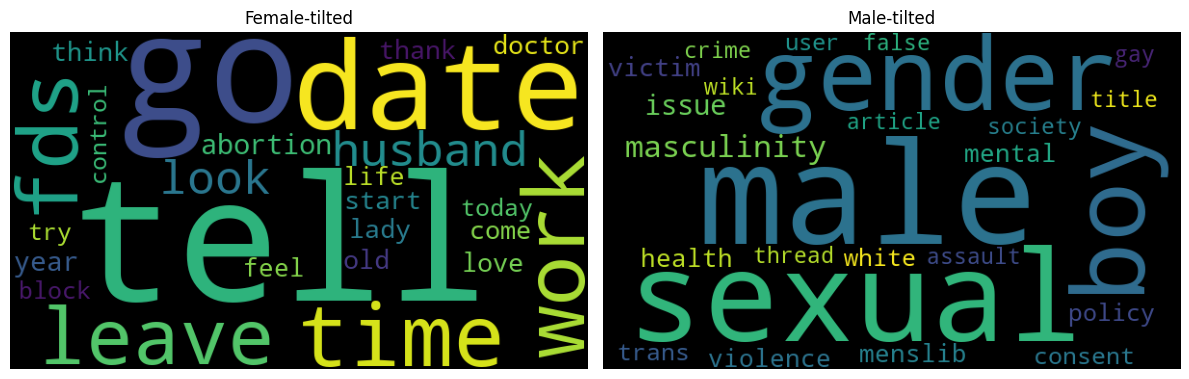

In [54]:
from wordcloud import WordCloud
wc_f = WordCloud(width=600, height=350).generate_from_frequencies(dict(zip(top_female.word, top_female.gap)))
wc_m = WordCloud(width=600, height=350).generate_from_frequencies(dict(zip(top_male.word,  -top_male.gap)))  # invert so size ~ importance

import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.subplot(1,2,1); plt.imshow(wc_f); plt.axis('off'); plt.title('Female-tilted')
plt.subplot(1,2,2); plt.imshow(wc_m); plt.axis('off'); plt.title('Male-tilted')
plt.tight_layout(); plt.show()

---

## 10. Save Results



In [52]:

df.to_csv("reddit_gender_sentiment.csv", index=False)




> The final dataset is saved for further inspection or downstream analysis.

---

## Summary

This notebook operationalizes a mixed-methods NLP approach to investigate gendered expression in Reddit discourse. Drawing on prior sociolinguistic research and NLP tools, it reveals both topic-level and emotional differences between male- and female-oriented communities.
